In [1]:
import numpy as np
from itertools import accumulate
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from icecream import ic

c:\Users\andrea\Desktop\py_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
DENSITY = 0.2  
rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [4]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

In [7]:
def valid(solution):
    """Controlla se la soluzione è valida (copre tutto l'universo)."""
    return np.all(np.sum(SETS[solution], axis=0) > 0)

def cost(solution):
    """Calcola il costo di una soluzione."""    
    return COSTS[solution].sum()

In [8]:
def satisfied_count(solution):
    """Restituisce il numero di elementi nell'universo che sono coperti dai set selezionati."""
    covered_elements = np.sum(SETS[solution], axis=0) > 0
    return np.sum(covered_elements)


This function is used to count the number of elements covered by the current solution.

In [9]:
def weighted_mutation(solution, strength):
    """Effettua la mutazione sulla soluzione con probabilità basata sui costi."""
    inverted_costs = 1 / COSTS
    probabilities = inverted_costs / inverted_costs.sum()
    mask = rng.random(NUM_SETS) < strength * probabilities
    if not np.any(mask):
        selected_set = rng.choice(NUM_SETS, p=probabilities)
        mask[selected_set] = True
    new_solution = np.logical_xor(solution, mask)
    return new_solution

With this code we aim at tweak the solution depending the cost of the set: sets with lower cost will be tweaked with more probability.

In [12]:
def fitness(solution: np.ndarray):
    """Restituisce la fitness di una soluzione, bilanciando costo e copertura."""    
    coverage = satisfied_count(solution)
    cost_value = -1 * cost(solution)
    return (coverage, cost_value)

soluzione iniziale trovata con costo -4276253.407593962


100%|██████████| 184/184 [00:01<00:00, 119.61it/s]


ris finale -1843268.6837663846


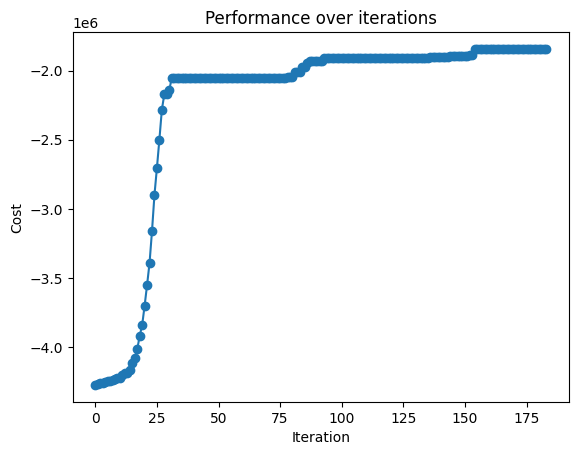

In [11]:
# Punto di partenza:
solution= rng.random(NUM_SETS)<1
print("soluzione iniziale trovata con costo", fitness(solution)[1])
history = []

buffer = []
BUF_LENGTH = int(int(DENSITY*100 * np.log(UNIVERSE_SIZE)) / 7)
solution_fitness = (0, -np.inf) 

step_size = 0.1

for steps in tqdm(range(int(DENSITY*100 * np.log(UNIVERSE_SIZE)))):
    if steps < int(DENSITY*100 * np.log(UNIVERSE_SIZE)) * 0.2:
        new_solution = weighted_mutation(solution, strength=step_size * 4) 
    else:
        new_solution = weighted_mutation(solution, strength=step_size)

    new_fitness = fitness(new_solution)
    
    buffer.append(new_fitness > solution_fitness)
    
    # Se trovo una soluzione migliore, aggiorno
    if new_fitness > solution_fitness:
        solution_fitness = new_fitness
        solution = new_solution

    history.append(float(solution_fitness[1]))

    if len(buffer) > BUF_LENGTH:
        buffer.pop(0)

    if np.sum(buffer) > 1:
        step_size = step_size + 0.3*step_size
    else:
        step_size = step_size - 0.3*step_size

print("ris finale", fitness(solution)[1])
plt.plot(range(0, len(history)), history, marker='o')  
plt.title("Performance over iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()
